<a href="https://colab.research.google.com/github/qyugit/WiDS2021/blob/main/WiDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [10]:
# load data 
train = pd.read_csv("drive/My Drive/WiDS/data/TrainingWiDS2021.csv")
test = pd.read_csv("drive/My Drive/WiDS/data/UnlabeledWiDS2021.csv")
test = test.sort_values(by='encounter_id')     # order test data as per solution template

In [247]:
# check if data loaded correctly
train_raw.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [248]:
# check if load correctly
test.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,...,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
370,371,135000,10055,64,NaN,1,Caucasian,F,157.5,Operating Room,Operating Room / Recovery,92,admit,CTICU,1.063194,0,NaN,NaN,203.0,1206.03,1,0,NaN,13.0,0.65,0.6,4.0,6.0,0.0,5.0,175.0,80.0,25.0,1,56.0,54.0,54.0,137.0,7.21,10.0,...,NaN,9.2,9.2,28.0,28.0,1.2,1.0,NaN,NaN,82.0,82.0,NaN,NaN,NaN,NaN,13.0,13.0,54.0,39.0,7.330,7.210,500.0,70.0,387.5,200.0,49.0,44.0,7.31,7.28,500.0,122.0,244.0,244.0,0,0,0,0,0,0,0
6207,6208,135001,10174,58,20.7,0,Caucasian,M,177.8,Floor,Floor,895,admit,Med-Surg ICU,0.008333,0,65.3,NaN,124.0,306.01,0,0,NaN,14.0,0.90,NaN,4.0,6.0,0.0,5.0,87.0,111.0,31.2,0,65.0,NaN,NaN,NaN,NaN,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3683,3684,135002,10101,65,27.5,0,Caucasian,M,177.8,NaN,Accident & Emergency,561,admit,Med-Surg ICU,0.102778,0,86.8,NaN,304.0,301.02,0,0,NaN,NaN,NaN,0.4,1.0,1.0,0.0,1.0,NaN,124.0,NaN,1,69.0,33.0,33.0,63.0,7.38,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,26.0,7.420,7.380,63.0,60.0,157.5,157.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3686,3687,135003,10101,57,18.6,0,Caucasian,M,182.8,Emergency Department,Accident & Emergency,561,admit,Med-Surg ICU,0.054167,0,62.1,NaN,120.0,407.01,0,0,NaN,NaN,NaN,NaN,2.0,5.0,0.0,3.0,165.0,114.0,NaN,0,112.0,NaN,NaN,NaN,NaN,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,48.0,7.400,7.210,110.0,108.0,360.0,360.0,74.0,74.0,7.21,7.21,110.0,110.0,NaN,NaN,0,0,0,0,0,0,0
10011,10012,135004,10078,36,30.2,0,Caucasian,M,172.7,Emergency Department,Accident & Emergency,1106,admit,MICU,0.140278,0,90.0,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,2.0,4.0,0.0,1.0,NaN,116.0,NaN,0,119.0,NaN,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.8,32.8,7.461,7.461,94.0,94.0,313.3,313.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0


# Data Preprocessing

In [11]:
# get train labels
train_labels = train['diabetes_mellitus']
train = train.drop(['Unnamed: 0', 'diabetes_mellitus', 'encounter_id'], axis=1)
test = test.drop(['Unnamed: 0', 'encounter_id'], axis=1)

print("Train:", train.shape)
print("Test:", test.shape)
print("Train Labe:", train_labels)

Train: (130157, 178)
Test: (10234, 178)
Train Labe: 0         1
1         1
2         0
3         0
4         0
         ..
130152    0
130153    0
130154    1
130155    0
130156    0
Name: diabetes_mellitus, Length: 130157, dtype: int64


In [251]:
# group columns by datatypes
# source: https://stackoverflow.com/questions/22470690/get-list-of-pandas-dataframe-columns-based-on-data-type
cols_by_dtype = train.columns.to_series().groupby(train.dtypes).groups
cols_by_dtype = {k.name: v for k, v in cols_by_dtype.items()}
cols_by_dtype

{'float64': Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'albumin_apache',
        'apache_2_diagnosis', 'apache_3j_diagnosis', 'bilirubin_apache',
        'bun_apache',
        ...
        'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
        'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
        'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
        'h1_pao2fio2ratio_min'],
       dtype='object', length=157),
 'int64': Index(['hospital_id', 'elective_surgery', 'icu_id', 'readmission_status',
        'apache_post_operative', 'arf_apache', 'intubated_apache',
        'ventilated_apache', 'aids', 'cirrhosis', 'hepatic_failure',
        'immunosuppression', 'leukemia', 'lymphoma',
        'solid_tumor_with_metastasis'],
       dtype='object'),
 'object': Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
        'icu_stay_type', 'icu_type'],
       dtype='object')}

## Summaries for numeric variables

In [252]:
# summaries for key numeric variables
demo = ['age', 'bmi', 'height', 'pre_icu_los_days', 'weight']
train[demo].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,125169.0,61.995103,16.822880,0.000000,52.000000,64.000000,75.000000,89.000000
bmi,125667.0,29.110260,8.262776,14.844926,23.598006,27.564749,32.803127,67.814990
height,128080.0,169.607219,10.833085,137.200000,162.500000,170.100000,177.800000,195.590000
pre_icu_los_days,130157.0,0.839933,2.485337,-0.250000,0.045833,0.155556,0.423611,175.627778
weight,126694.0,83.791104,24.963063,38.600000,66.500000,80.000000,96.800000,186.000000


In [227]:
# check how many age 0 and under 18, and diabetes rate
age0 = train[train.age ==0]['encounter_id'].count()
diabetesAge0 = train[train.age ==0]['diabetes_mellitus'].sum()
age1To12 = train[(0< train.age) & (train.age <= 12)]['encounter_id'].count()
age12To18 = train[(12< train.age) & (train.age <= 18)]['encounter_id'].count() 
diabetesAge12To18 = train[(12< train.age) & (train.age <= 18)]['diabetes_mellitus'].sum()

print('Age 0:', age0, '; diabetes:', diabetesAge0,
      '\n1-12:', age1To12,
      '\n12-18:', age12To18, '; diabetes:', diabetesAge12To18) 

Age 0: 30 ; diabetes: 3 
1-12: 0 
12-18: 642 ; diabetes: 78


**Observations**

*   Age min = 0.000, can be treated differently. Also not many data points from adolescents under 18.
*   A group of patients with negative pre_icu_los_status, meaning they were admitted into ICU before hospital admission, probabily and indicator of more severe and urgent symptoms. 


**Next step**

*   Recode age based on [CDC](https://www.cdc.gov/diabetes/pdfs/data/statistics/national-diabetes-statistics-report.pdf)'s grouping with two new groups 0 and under 18.



## Bucketizing numeric variables
### Age

In [253]:
# age group
def ageGroup(df):
  for row in df.itertuples():
    if df.at[row.Index, 'age'] == 0:
        df.at[row.Index, 'age_group'] = '0'
    elif (df.at[row.Index, 'age'] > 0) & (df.at[row.Index, 'age'] < 18):
        df.at[row.Index, 'age_group'] = '1-17'
    elif (df.at[row.Index, 'age'] >= 18) & (df.at[row.Index, 'age'] < 45):
        df.at[row.Index, 'age_group'] = '18-44'
    elif (df.at[row.Index, 'age'] >= 45) & (df.at[row.Index, 'age'] < 65):
        df.at[row.Index, 'age_group'] = '44-65'
    elif df.at[row.Index, 'age'] >= 65:
        df.at[row.Index, 'age_group'] = '65+'        

In [254]:
# Group age for both train and test data
ageGroup(train)
ageGroup(test)

In [255]:
# check if grouped correctly
train[['age', 'age_group']]

,age,age_group
0,68.0,65+
1,77.0,65+
2,25.0,18-44
3,81.0,65+
4,19.0,18-44
...,...,...
130152,50.0,44-65
130153,79.0,65+
130154,73.0,65+
130155,81.0,65+


## Summaries for object variables

In [231]:
# summaries for object variables
train.describe(include=[object])

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,age_group
count,128570,130091,96959,129917,130157,130157,125169
unique,6,2,15,5,3,8,5
top,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,65+
freq,100236,70518,51258,76846,124741,71468,61749


In [ ]:
train.ethnicity.unique()

array(['Caucasian', nan, 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'], dtype=object)

In [ ]:
train.hospital_admit_source.unique()

array(['Floor', 'Emergency Department', 'Operating Room', nan,
       'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU',
       'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)',
       'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other'],
      dtype=object)

In [ ]:
train.icu_admit_source.unique()

array(['Floor', 'Accident & Emergency', 'Operating Room / Recovery',
       'Other Hospital', 'Other ICU', nan], dtype=object)

In [ ]:
train.icu_stay_type.unique()

array(['admit', 'readmit', 'transfer'], dtype=object)

In [ ]:
train.icu_type.unique()

array(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'], dtype=object)

## Missing values
### Integer features

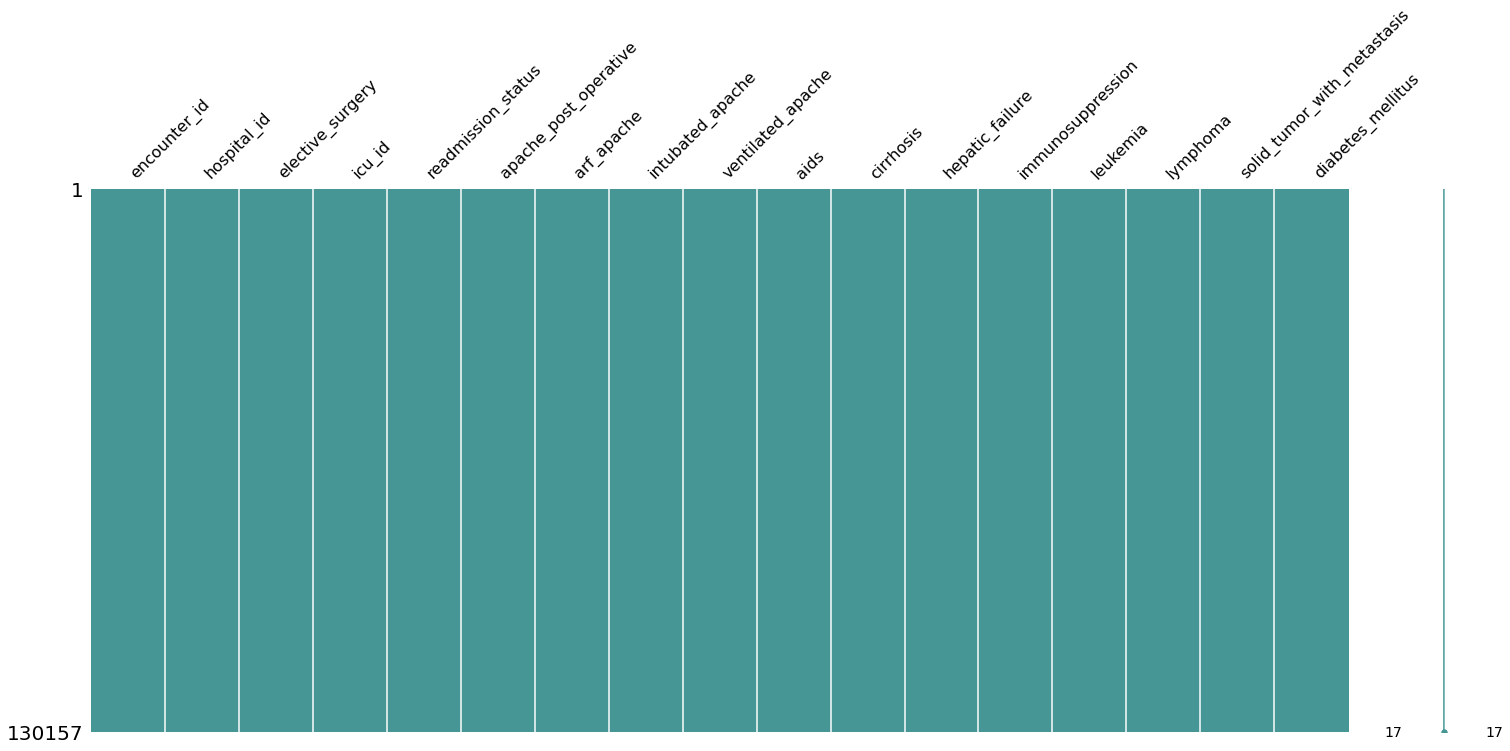

In [ ]:
msno.matrix(train[cols_by_dtype['int64']], color = (0.28, 0.59, 0.59))
plt.show()

No missing value in interger type features.

### Object features

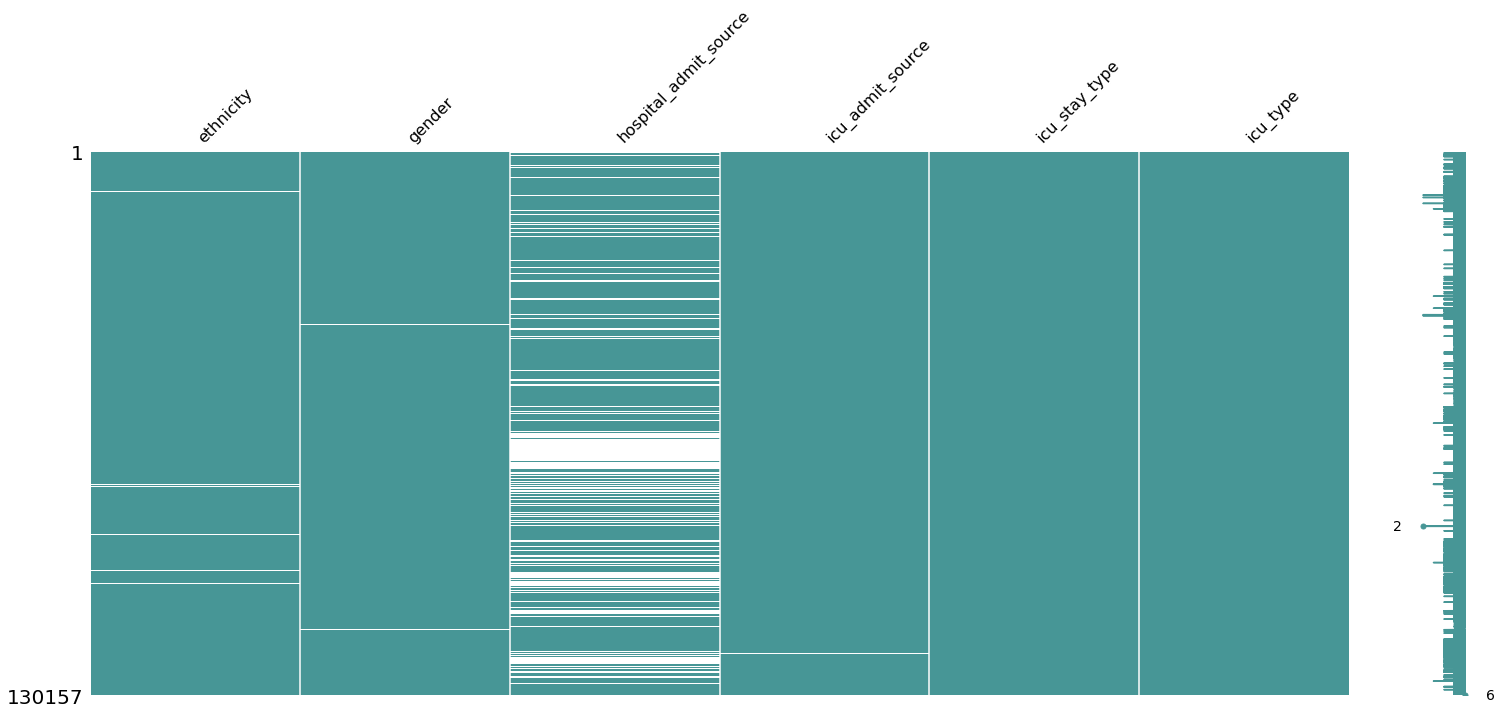

In [ ]:
msno.matrix(train[cols_by_dtype['object']], color = (0.28, 0.59, 0.59))
plt.show()

A lot missing values in hosipital_admit_source.

### Float features

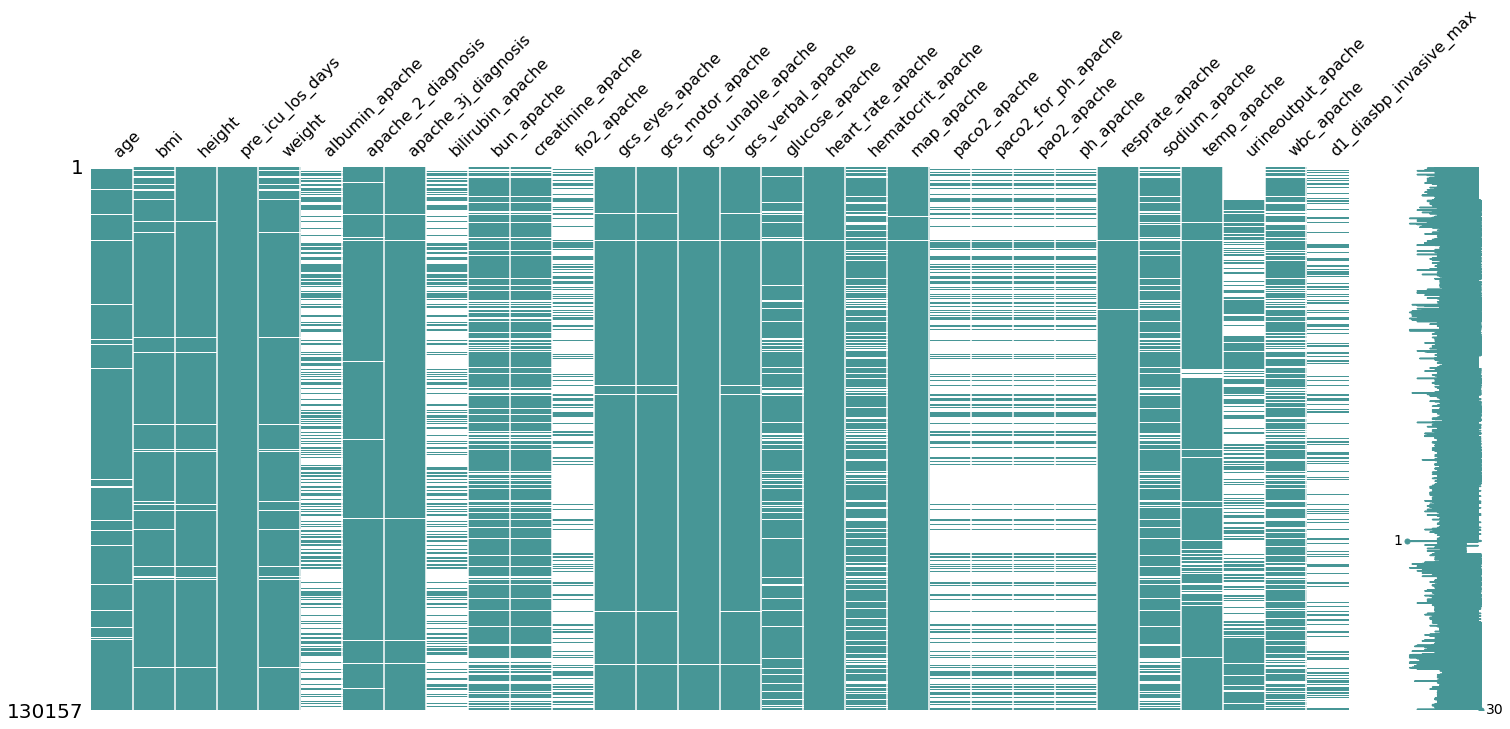

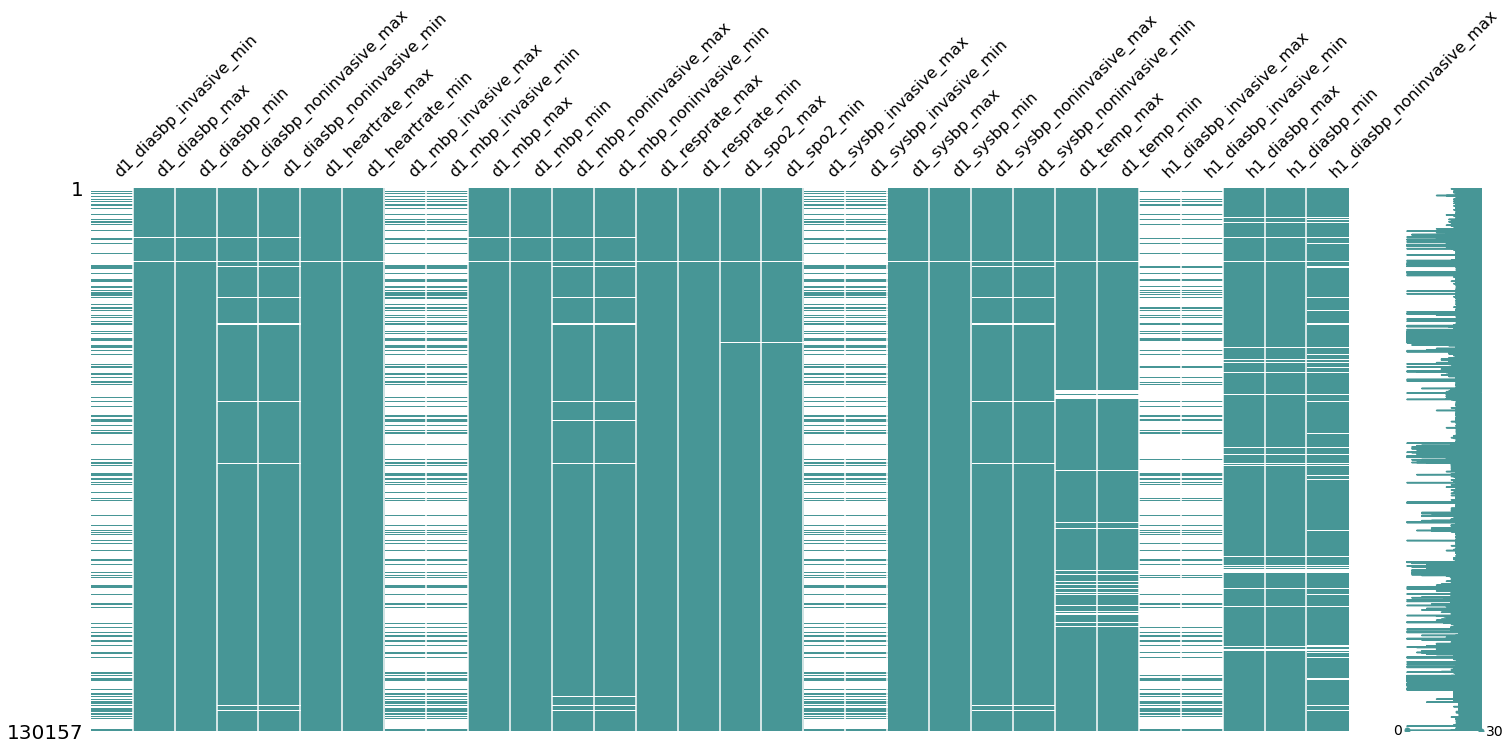

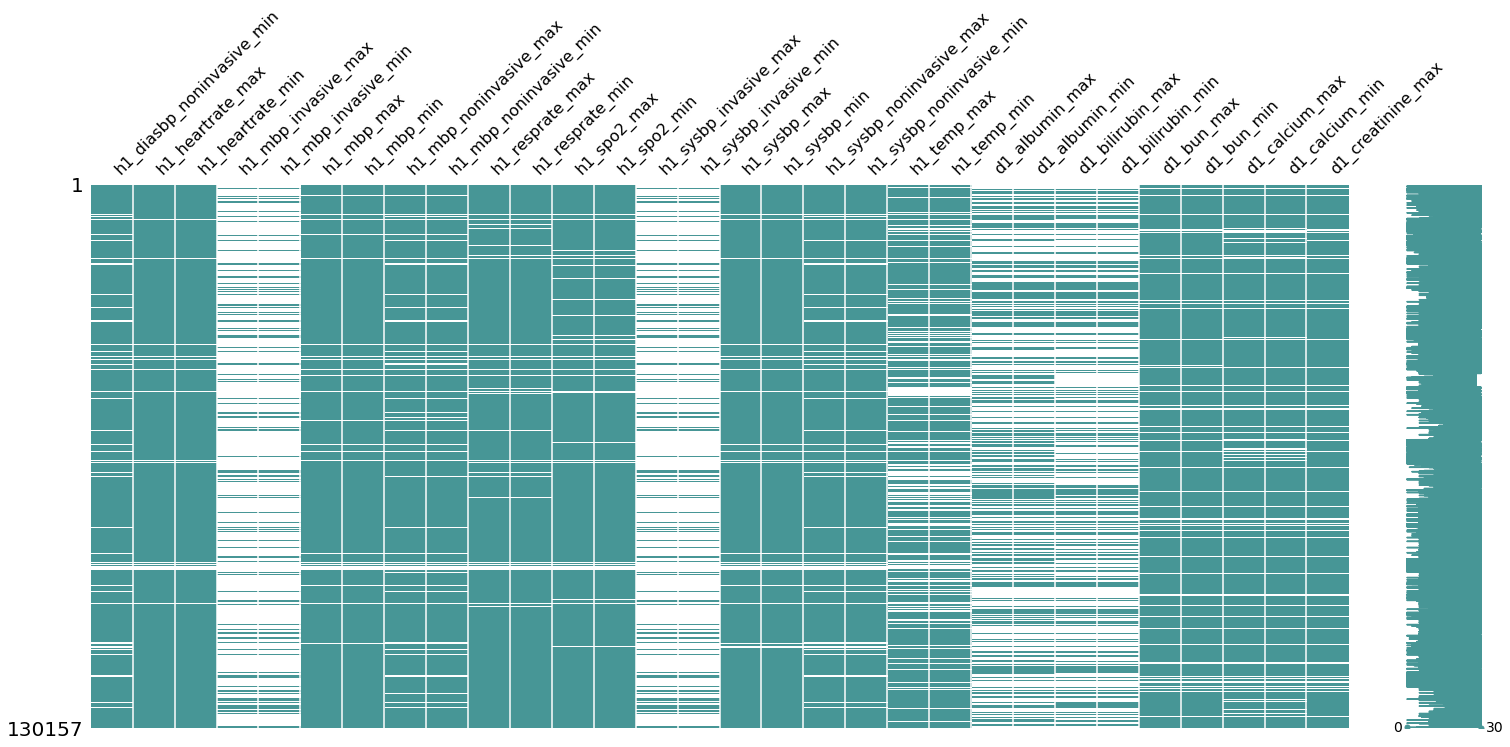

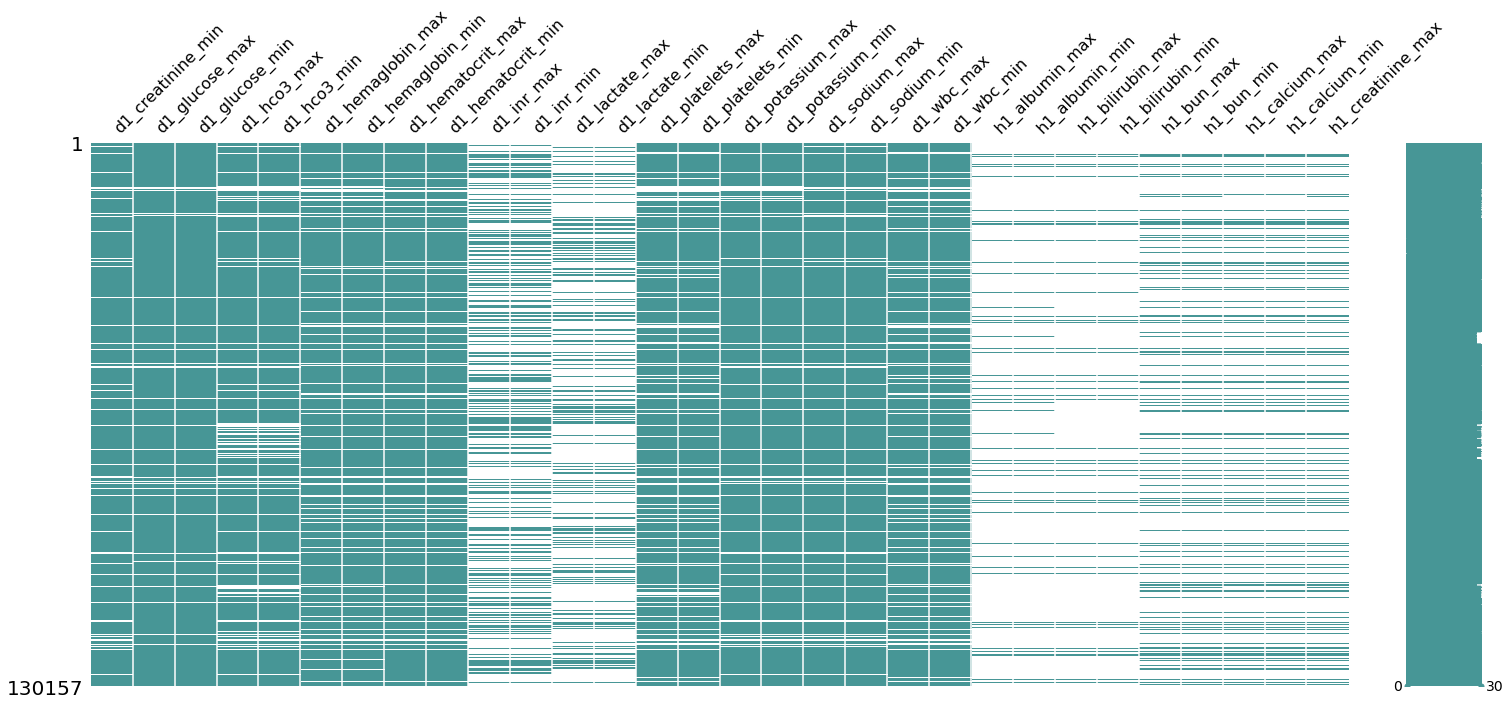

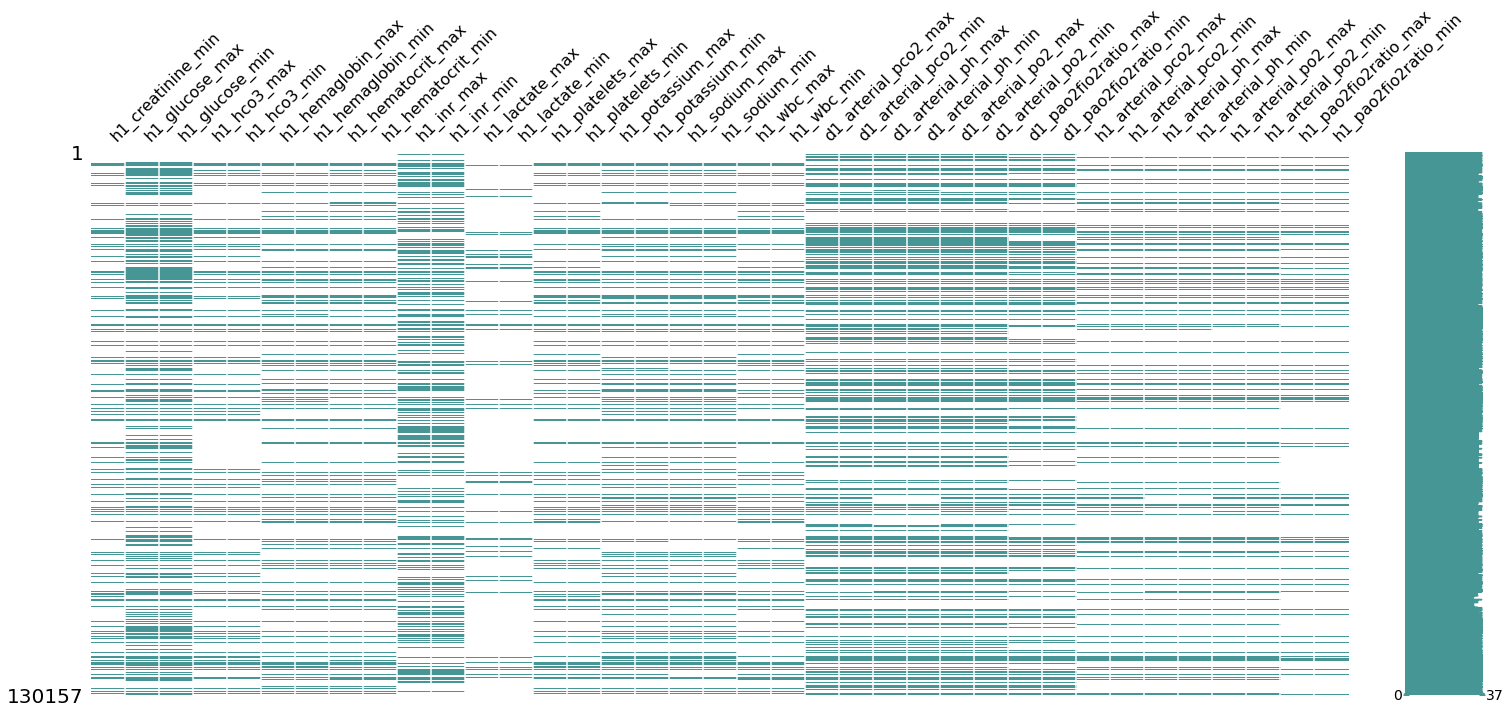

In [ ]:
msno.matrix(train[cols_by_dtype['float64'][:30]], color = (0.28, 0.59, 0.59))
msno.matrix(train[cols_by_dtype['float64'][30:60]], color = (0.28, 0.59, 0.59))
msno.matrix(train[cols_by_dtype['float64'][60:90]], color = (0.28, 0.59, 0.59))
msno.matrix(train[cols_by_dtype['float64'][90:120]], color = (0.28, 0.59, 0.59))
msno.matrix(train[cols_by_dtype['float64'][120:]], color = (0.28, 0.59, 0.59))
plt.show()

**Obseration**: 
A great deal of missing values in a lot of the h1_ features (1st hr of ICU stay) and some of the d1_ features (first 24 hr of ICU stay). 

**Possible reasons**: 
*   An indication of severeness, more severe cases got more comprehensive tests, thus maybe helpful in predicting diabetes.
*   Due to hospital/state (regulation) difference, thus not indicative of diabetes or not.

### Remove certain missing values

In [ ]:
def miss_val_percent(df, thresh = 80.0):
    """
    Remove features that have a missing value percentage greater than 80%
    """
    mvp = ((df.isnull().sum()) / (len(df))) * 100
    return mvp[mvp > thresh]

In [ ]:
# all with more than 80% values missing; remove them; do it for both train and test features

# create retained features list
retained_features = set(train.columns) - set(miss_val_percent(train).index) 

# subset train and test sets
train = train[retained_features]

retained_features.remove('diabetes_mellitus')
test = test[retained_features]

# check
print("Train:", train.shape)
print("Test:", test.shape)

Train: (130157, 149)
Test: (10234, 148)


Set threshold at 80%, 147 features (82.1%) retained.

If set at 90% threshold, 96.6% of features were retained. 


In [ ]:
def get_row_miss_percent(df):
    """
    Adds a feature into the dataframe indicating the missing
    value percentage of the corresponding row
    """
    ncols = df.shape[1]
    df['miss_percent'] = (df.isnull().sum(axis=1) / ncols) * 100
    
    return df

In [ ]:
# calculate missing percent per row for train and test
get_row_miss_percent(train)
get_row_miss_percent(test)

# subset train
train = train.loc[train['miss_percent'] < 50]

# check
print("Train:", train.shape)
print("Test:", test.shape)

Train: (129049, 150)
Test: (10234, 149)


In [257]:
# check
print("Train:", train.shape)
print("Test:", test.shape)

Train: (130157, 179)
Test: (10234, 179)


### Imputation


#### KNN

In [258]:
# update cols_by_dtype
cols_by_dtype = train.columns.to_series().groupby(train.dtypes).groups
cols_by_dtype = {k.name: v for k, v in cols_by_dtype.items()}
cols_by_dtype

{'float64': Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'albumin_apache',
        'apache_2_diagnosis', 'apache_3j_diagnosis', 'bilirubin_apache',
        'bun_apache',
        ...
        'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
        'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
        'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
        'h1_pao2fio2ratio_min'],
       dtype='object', length=157),
 'int64': Index(['hospital_id', 'elective_surgery', 'icu_id', 'readmission_status',
        'apache_post_operative', 'arf_apache', 'intubated_apache',
        'ventilated_apache', 'aids', 'cirrhosis', 'hepatic_failure',
        'immunosuppression', 'leukemia', 'lymphoma',
        'solid_tumor_with_metastasis'],
       dtype='object'),
 'object': Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
        'icu_stay_type', 'icu_type', 'age_group'],
       dtype='object')}

In [259]:
train_variables = train[cols_by_dtype['object']]
train_dummies = pd.get_dummies(train_variables,drop_first = True)
train_dummies.head()

,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_ICU to SDU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,age_group_1-17,age_group_18-44,age_group_44-65,age_group_65+
0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [260]:
train = train.drop(cols_by_dtype['object'], axis=1)
train = pd.concat([train, train_dummies], axis=1)
train.head()

,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,...,leukemia,lymphoma,solid_tumor_with_metastasis,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_ICU to SDU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,age_group_1-17,age_group_18-44,age_group_44-65,age_group_65+
0,118,68.0,22.732803,0,180.3,92,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,...,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,81,77.0,27.421875,0,160.0,90,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,118,25.0,31.952749,0,172.7,93,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,36.7,NaN,0,NaN,NaN,NaN,88.0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,118,81.0,22.635548,1,165.1,92,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,34.8,NaN,1,8.0,62.0,30.0,48.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,33,19.0,NaN,0,188.0,91,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,36.7,NaN,0,NaN,NaN,NaN,99.0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [261]:
test_variables = test[cols_by_dtype['object']]
test_dummies = pd.get_dummies(test_variables,drop_first = True)
test_dummies.head()

,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU to SDU,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,age_group_44-65,age_group_65+
370,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
6207,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3683,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3686,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
10011,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [262]:
test = test.drop(cols_by_dtype['object'], axis=1)
test = pd.concat([test, test_dummies], axis=1)
test.head()

,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU to SDU,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,age_group_44-65,age_group_65+
370,10055,64,NaN,1,157.5,92,1.063194,0,NaN,NaN,203.0,1206.03,1,0,NaN,13.0,0.65,0.6,4.0,6.0,0.0,5.0,175.0,80.0,25.0,1,56.0,54.0,54.0,137.0,7.21,10.0,143.0,36.60,NaN,1,13.0,72.0,46.0,76.0,...,122.0,244.0,244.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
6207,10174,58,20.7,0,177.8,895,0.008333,0,65.3,NaN,124.0,306.01,0,0,NaN,14.0,0.90,NaN,4.0,6.0,0.0,5.0,87.0,111.0,31.2,0,65.0,NaN,NaN,NaN,NaN,47.0,137.0,36.80,NaN,0,7.5,NaN,NaN,76.0,...,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3683,10101,65,27.5,0,177.8,561,0.102778,0,86.8,NaN,304.0,301.02,0,0,NaN,NaN,NaN,0.4,1.0,1.0,0.0,1.0,NaN,124.0,NaN,1,69.0,33.0,33.0,63.0,7.38,37.0,NaN,37.44,892.0,1,NaN,NaN,NaN,83.0,...,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3686,10101,57,18.6,0,182.8,561,0.054167,0,62.1,NaN,120.0,407.01,0,0,NaN,NaN,NaN,NaN,2.0,5.0,0.0,3.0,165.0,114.0,NaN,0,112.0,NaN,NaN,NaN,NaN,31.0,NaN,36.66,2545.0,1,NaN,NaN,NaN,92.0,...,110.0,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
10011,10078,36,30.2,0,172.7,1106,0.140278,0,90.0,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,2.0,4.0,0.0,1.0,NaN,116.0,NaN,0,119.0,NaN,NaN,NaN,NaN,8.0,NaN,37.20,3161.0,1,NaN,NaN,NaN,92.0,...,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [263]:
imputer = KNNImputer(n_neighbors=5)
train_filled = pd.DataFrame(imputer.fit_transform(train),columns = train.columns) # train data
test_filled = pd.DataFrame(imputer.fit_transform(test),columns = test.columns) # test data

In [264]:
# save to drive
train_filled.to_csv('drive/My Drive/WiDS/train_filled.csv')
test_filled.to_csv('drive/My Drive/WiDS/test_filled.csv')

In [7]:
train_filled = pd.read_csv('drive/My Drive/WiDS/train_filled.csv')
test_filled = pd.read_csv('drive/My Drive/WiDS/test_filled.csv')

In [8]:
# remove cols from train that are not present in test
train_filled = train_filled[test_filled.columns]

In [12]:
print("Train:", train_filled.shape)
print("Train label:", train_labels.shape)

Train: (130157, 203)
Train label: (130157,)


#### Median

In [ ]:
# create the categorical imputer object
cat_imputer = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = "missing")

# subset data to have only categorical features
train_cat = train[cols_by_dtype['object']]
test_cat = test[cols_by_dtype['object']]

# impute
train_cat.iloc[:, :] = cat_imputer.fit_transform(train_cat)
test_cat.iloc[:, :] = cat_imputer.fit_transform(test_cat)

In [ ]:
# create the continuous imputer object
cont_imputer = SimpleImputer(missing_values = np.nan, strategy = "median")

# subset data to have only continuous features
train_cont_int = train[cols_by_dtype['int64']]
train_cont_float = train[cols_by_dtype['float64']]
test_cont_int = test[cols_by_dtype['int64']]
test_cont_float = test[cols_by_dtype['float64']]

# impute
train_cont_int.iloc[:, :] = cont_imputer.fit_transform(train_cont_int)
train_cont_float.iloc[:, :] = cont_imputer.fit_transform(train_cont_float)
test_cont_int.iloc[:, :] = cont_imputer.fit_transform(test_cont_int)
test_cont_float.iloc[:, :] = cont_imputer.fit_transform(test_cont_float)

In [ ]:
train_filled = pd.concat([train_cat, train_cont_int, train_cont_float], axis=1)
test_fiiled = pd.concat([test_cat, test_cont_int, test_cont_float], axis=1)

# check
print("Train:", train_filled.shape)
print("Test:", test_fiiled.shape)

In [ ]:
print("The missing values in the train dataset are:", train_filled.isnull().sum().sum())

The missing values in the train dataset are: 0


# Models

## Logistic Regression


In [15]:
# create standard scaler object with training data
scaler = StandardScaler().fit(train_filled)

# apply scaler to train and test data
train_filled = pd.DataFrame(scaler.transform(train_filled))
test_filled = pd.DataFrame(scaler.transform(test_filled))

# check
print("Train:", train_filled.shape)
print("Test:", test_filled.shape)

Train: (130157, 203)
Test: (10234, 203)


In [16]:
# split data (consider only training data for now)
X_train, X_test, y_train, y_test = train_test_split(train_filled, train_labels, test_size=0.2, random_state=42)

### logreg

Accuracy: 81 %


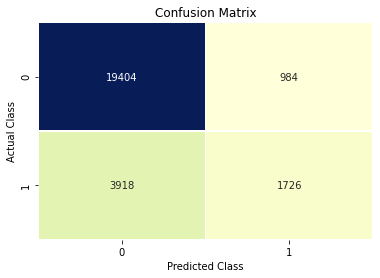

In [272]:
# make a logistic regression object; use default parameters for now
logreg = LogisticRegression()

# fit classifier
logreg.fit(X_train, y_train)

# make predictions
y_pred = logreg.predict(X_test)

# evaluate with a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# print accuracy
print("Accuracy:", int(round(logreg.score(X_test, y_test), 2)*100), '%')

# credits to code below - https://realpython.com/logistic-regression-python/#logistic-regression-in-python-with-scikit-learn-example-1
sns.heatmap(cm, annot=True, cbar=False, cmap='YlGnBu', fmt='d', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

#### Update Solution

In [19]:
# load solution template
solution = pd.read_csv('drive/My Drive/WiDS/samples&templates/SolutionTemplateWiDS2021.csv')

In [274]:
# update submission
solution['diabetes_mellitus'] = logreg.predict_proba(test_filled)[:, 1]

In [278]:
# save solution
solution.to_csv("drive/My Drive/WiDS/submissions/logreg.csv", index=False)

### SGDClassifier

In [37]:
# make SGD models
SGD_log = SGDClassifier(loss = 'log', penalty = 'l1') # l1 better than l2 in submission

#### log

Accuracy: 81 %


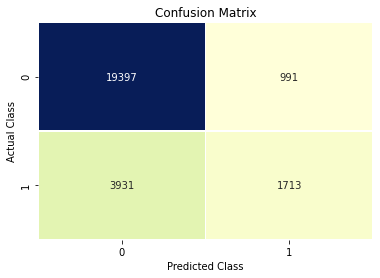

In [34]:
# fit classifier
SGD_log.fit(X_train, y_train)

# make predictions
y_pred = SGD_log.predict(X_test)

# evaluate with a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# print accuracy
print("Accuracy:", int(round(SGD_log.score(X_test, y_test), 2)*100), '%')

# credits to code below - https://realpython.com/logistic-regression-python/#logistic-regression-in-python-with-scikit-learn-example-1
sns.heatmap(cm, annot=True, cbar=False, cmap='YlGnBu', fmt='d', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [31]:
# update submission
solution['diabetes_mellitus'] = SGD_log.predict_proba(test_filled)[:, 1]

In [32]:
# save solution
solution.to_csv("drive/My Drive/WiDS/submissions/SGDlog.csv", index=False)